<h1 style="text-align: center; font-family: Arial"> Projet Final - GBM8770 </h1>
<h2 style="text-align: center; font-family: Arial"> Multi-Scale Line Detector</h2>

Par Renato Castillo (1962797) et Karl-Philippe Beaudet (1958657)

In [1]:
%load_ext autoreload
%autoreload 2

# Importe les modules qui seront utilisé dans le laboratoire.
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import cv2
%matplotlib inline
# Étend la taille des figures
plt.rcParams["figure.figsize"] = (18, 8)

In [2]:
# Importe la classe MSLD et la fonction load_dataset définie dans le dossier MSLD.py
from MSLD import MSLD, load_dataset

# Partie I: Implémentation de la MSLD

### Préparatifs
<p style='text-align:center'>
Dans un soucis d’optimisation de l’implémentation, nous allons utiliser des convolutions dès que cela est possible. Particulièrement pour le calcul des moyennes d’intensités sur une fenêtre de taille W et le long des lignes de longueur L.  
De plus ces masques ne seront calculés qu’une seule fois, lors de l’instanciation de la classe MSLD.
</p>

**Q1.** Donnez la valeur du masque permettant le calcul de la valeur moyenne d’une fenêtre de taille W.   
Puis complétez le constructeur de la classe MSLD en définissant avg_mask.


Afin de calculer la valeur moyenne d'une fenêtre de taille W, on construit un masque de type moyenneur.

$$
masque = \frac{1}{W^2}*I_{WxW}
$$

Où *I* est la matrice identité de taille *WxW*. Ainsi, en applicant ce masque on obtient la valeur moyenne d'une fenêtre.

**Q2.** Expliquez comment construire les masques permettant le calcul de la valeur moyenne le long de lignes de taille L pour n_orientation par rotations successives.  
Puis complétez le constructeur de la classe MSLD avec la définition de line_detectors_masks.


Afin de construire les masques pour calculer la moyenne le long de ligne de taille L pour n orientations, on construit une liste qui contient *n* éléments par chaque taille *L*. Ainsi, on débute la première orientation avec une matrice *LxL* où la ligne centrale a les valeurs de $\frac{1}{l}$. Après, on effectue des rotations de cette matrice avec des rotations de $\theta = \frac{180°}{n_{orientations}}$ afin d'éviter de répéter deux fois la même orientation d'une ligne. On met ensemble toutes les rotations effectuées sous une liste qu'on accède lorsqu'on applique l'algorithme du BSLD et le MSLD. Les moyennes au long de lignes de taille L sont ainsi calculées par des convolutions successives avec les éléments de la liste créée.

In [3]:
# Vous pouvez dès à présent instancier l’objet: msld=MSLD(W,L,n_orientation) 
# en remplaçant les hyper-paramètres W, L et n_orientation par leurs valeurs conseillées par l’article.

msld = MSLD(15, [1, 3, 5, 7, 9, 11, 13, 15], 12) #Application des échelles impaires pour la taille L

<p style='text-align: center'>
Pour entraîner et valider l’algorithme nous allons utiliser la base de données DRIVE fournie dans l'archive.
</p>

**Q3.** Complétez la fonction load_dataset() pour qu’elle charge et renvoie la base de données
d’entraînement et de test (en incluant pour chaque échantillon: l’image, le label et le masque).   
Puis affichez l’image, le label et le masque de la première image de l’ensemble d’entraînement.
*(On notera cette image I1.)*


C:\Users\kpbea\AppData\Local\Temp\ipykernel_228312\888273644.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


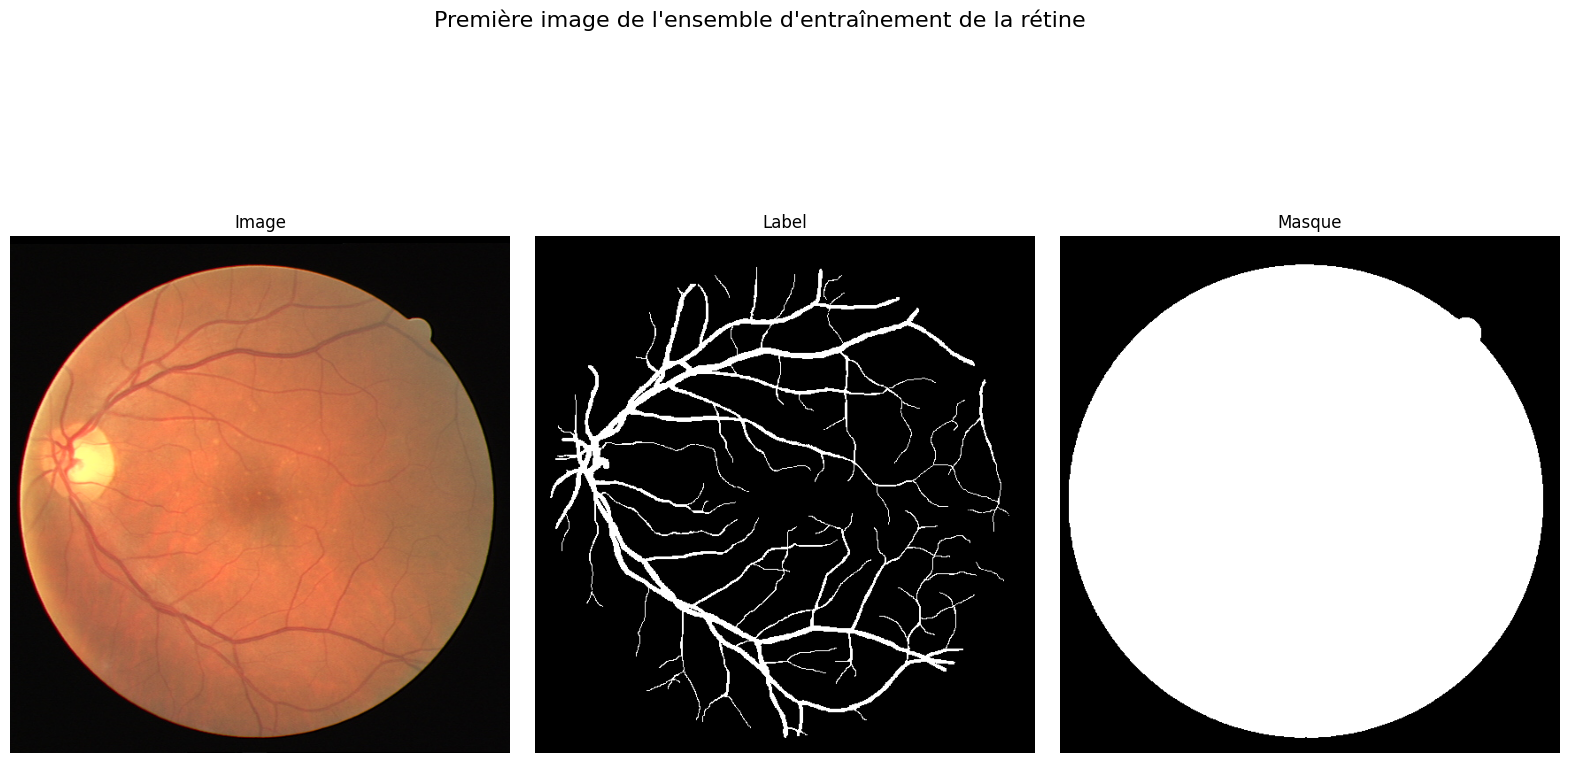

In [4]:
train, test = load_dataset()
I1 = train[0]

I1_Data = I1['image']
I1_Label = I1['label']
I1_Mask = I1['mask']

fig, img = plt.subplots(1,3)
fig.suptitle("Première image de l'ensemble d'entraînement de la rétine", fontsize=16)

img[0].imshow(I1_Data, vmin = 0, vmax = 1)
img[0].set_title('Image')
img[0].axis("off")

img[1].imshow(I1_Label, cmap='gray',vmin = 0, vmax = 1)
img[1].set_title('Label')
img[1].axis("off")

img[2].imshow(I1_Mask, cmap='gray',vmin = 0, vmax = 1)
img[2].set_title('Masque')
img[2].axis("off")

fig.set_size_inches(20,10) 
plt.subplots_adjust(wspace=.05) 
fig.show()

 ### Basic Line Detector

**Q4.** À l’aide de la section 3.1 de l’article, implémentez `basicLineDetector(grey_lvl, L)`.

**Q5.** Affichez la réponse du filtre appliqué à l’image I1 pour les longueurs L=1 et L=15. Comparez les
deux et commentez.   
*Attention le filtre BLD ne s’applique pas à tous les canaux de l’image. Relisez la section 3.1 de l’article
pour plus d’informations...*

C:\Users\kpbea\AppData\Local\Temp\ipykernel_228312\2304793967.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


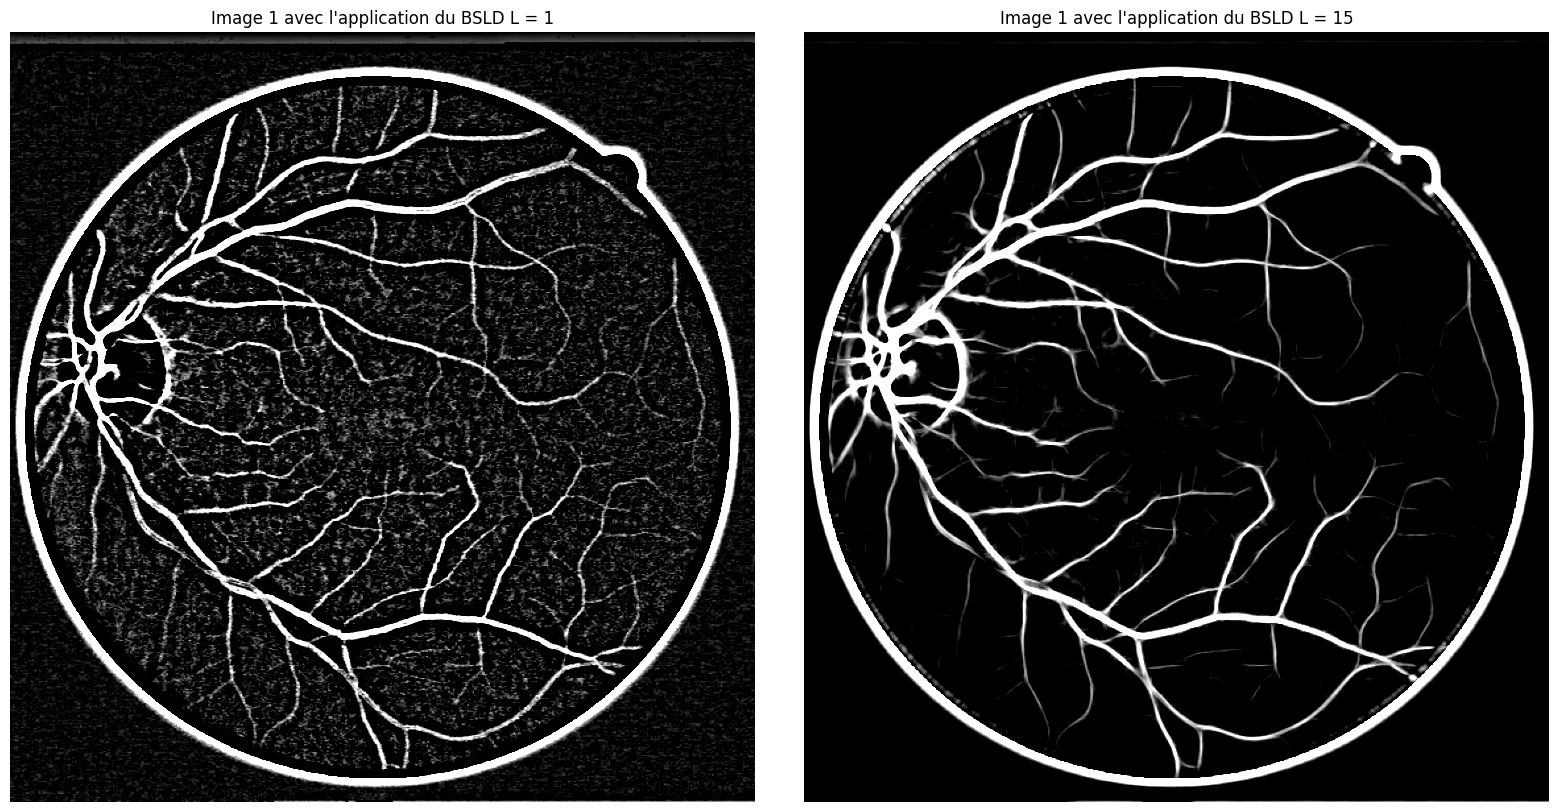

In [5]:
igrey_lvl_I1 = 1 - I1_Data[:,:,1]
I1_bld_L1 = msld.basicLineDetector(igrey_lvl_I1, L=1)
I1_bld_L15 = msld.basicLineDetector(igrey_lvl_I1, L=15)

fig2, img2 = plt.subplots(1,2)

img2[0].imshow(I1_bld_L1, cmap='gray', vmin=0, vmax=1.)
img2[0].set_title("Image 1 avec l'application du BSLD L = 1")
img2[0].axis("off")

img2[1].imshow(I1_bld_L15, cmap='gray', vmin=0, vmax=1.)
img2[1].set_title("Image 1 avec l'application du BSLD L = 15")
img2[1].axis("off")

fig2.set_size_inches(20,10)
plt.subplots_adjust(wspace=.05) 
fig2.show()

**Comparaison de la réponses des deux échelles du BSLD**

En appliquant le BSLD avec une longueur de $L=1$, on remarque que toutes lignes ont été détectées. Cependant étant donné qu'une longueur de 1 n'est pas suffisante pour distinguer uniquement les vaisseaux, il y a beaucoup de bruit dans la réponse car beaucoup d'éléments du fond sont admis. En effet, les structures de petite taille (1 pixel) dans l'image sont considérés comme des vaisseaux par le BSLD et par conséquent, elles sont rehaussées dans la réponse. 

En comparaison, en appliquant le BSLD avec une longueur de $L=15$, il est possible de remarquer que seulement les lignes ayant une longueur de plus de 15 pixels ont été détectées. Alors qu'une certaine quantité d'information relative aux lignes plus courtes a été perdue. Ce qui se traduit dans l'image *Image 1 avec l'application du BSLD L=15* avec l'absence de plusieurs petits vaisseaux.

Finalement, on remarque que pour les deux échelles du BSLD, il y a des défauts au niveau de la détection des vaisseaux dans les régions où deux vaisseaux se croissent. En outre ces défauts consistent en un manque de détection de vaisseaux dans ces régions ce qui concorde avec les problèmes du BSLD identifiés par les auteurs de l’article du MSLD. De plus, on remarque que le disque optique a aussi été réhaussé par le BSLD pour les deux tailles de *L*. Ainsi, on observe l'apparition d'un cercle dans la réponse au niveau de la jonction de plusieurs vaisseaux.


 ### Multi-Scale Line Detector

**Q6.** À l’aide de la section 3.2 et 3.3 de l’article et de la méthode `self.basicLineDetector(grey_lvl, L)` déjà implémentée, implémentez `multiScaleLineDetector(image)`.

**Q7.** Affichez le résultat de l’algorithme appliqué à l’image I1. Comparez avec les réponses du filtre
obtenues à la question Q5, et commentez.

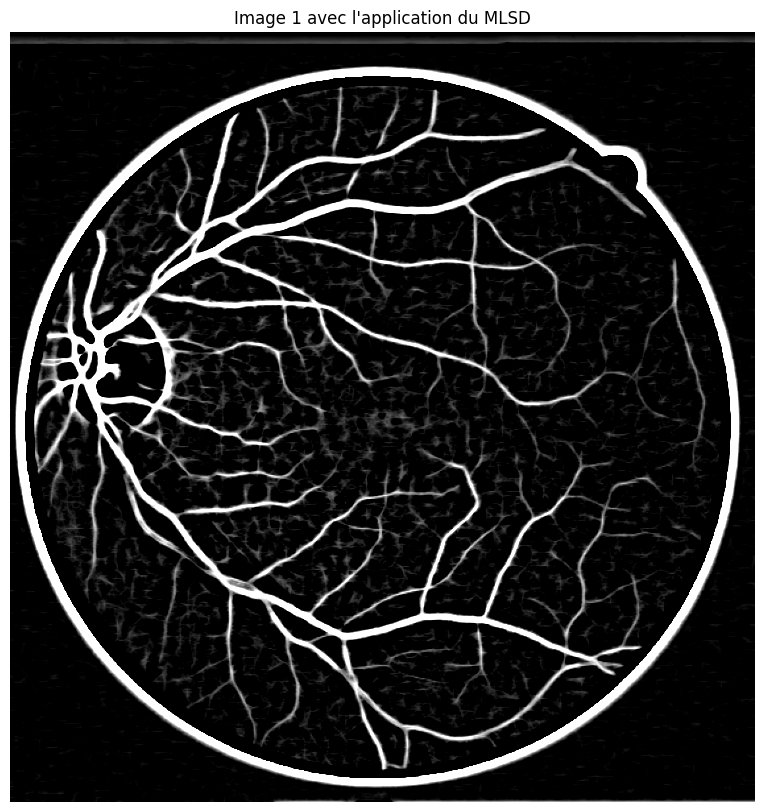

In [6]:
I1_msld = msld.multiScaleLineDetector(I1_Data)

plt.rcParams["figure.figsize"] = (12, 10)
plt.imshow(I1_msld, cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.title("Image 1 avec l'application du MLSD")
plt.show()

**Comparaison du MSLD et le BSLD**

En appliquant la méthode de MSLD, une combinaison linéaire des réponses du BSLD est appliquée. Ainsi, on établit un compromis entre les éléments qui seront amplifiés par l'algorithme et les échelles des masques moyennants. 

En comparaison de la réponse obtenue du MSLD avec celles du BSLD, on peut observer que le MSLD comporte une combinaison de toutes les échelles impaires de L du BSLD. Ainsi, la réponse inclue les vaisseaux de toutes les longueurs dictées par l'échelle L. Donc, on remarque que le MSLD permet de conserver plus d'information par rapport à la détection de vaisseaux sanguins de la rétine. Cependant, on remarque sur l'image que dans certaines zones où les vaisseaux se croisent, les pixels de vaisseaux ne sont pas réhaussés par l'algorithme. Aussi, malgré la diminution du bruit de fond, il y a encore la présence de granularités dans les espaces vides entre les vaisseaux détectés.
 


 ### Apprentissage du seuil
 
Pour calculer le seuil donnant la meilleure précision sur l’ensemble d’entraînement efficacement, nous
allons utiliser la courbe [ROC (Receiver Operating Characteristic)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic). Cette courbe sera étudiée en détail
dans la partie II. Pour le moment, il vous faut juste savoir qu’elle associe à chaque seuil possible, le
taux de faux positifs et le taux de vrais positifs si ce seuil était choisi.

 

**Q8.** Donnez la formule de la précision ACC (*accuracy* en anglais) en fonction du taux de faux positifs FPR, du taux de vrais positifs TPR, ainsi que du nombre de valeurs positives P, de valeurs négatives N et du nombre total de pixels S dans l’image de label.   
*(Vous pouvez vous aider des formules indiqués sur la page wikipédia de la courbe ROC.)*

$$
ACC = \frac{P*TPR + N(1 - FPR)}{S}
$$

Pour vous faire gagner du temps on vous donne la méthode qui calcule le tpr et le fpr associé à chaque seuil possible pour un dataset donné. Cette fonction utilise la fonction [`roc_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) de sklearn. Assurez-vous que vous comprenez bien chaque ligne du code.

**Q9.** Pourquoi est-il si important de ne sélectionner uniquement les pixels qui appartiennent au masque. En particulier, comment évoluerait la précision si on sélectionnait finalement tous les pixels de l'image? (Sachant que hors du masque la prédiction du msld est toujours nulle.)


Il est important de sélectionner seulement les pixel de la rétine pour les calculs de la précision. En outre, avec la selection de tous les pixels de l'image, on risque d'obtenir une précision globale très grande par rapport à la réalité. Effectivement, puisque la prédiction du fond est nulle, cela va diminuer le *FPR* et augmenter le total des négatifs *N* et pour la même quantité de pixel sur le label, le *ACC* va croître.


**Q10.** À l’aide de la méthode `self.roc(dataset)` et de la formule de la question 8, complétez la méthode
`learnThreshold(dataset)` qui identifie le seuil pour laquelle la précision est la plus élevée.

**Q11.** Utilisez cette fonction pour apprendre le seuil sur les images d’entraînement. Pour quelle raison faut il absolument conserver une partie des images (l’ensemble de test) et ne pas les utiliser pendant l’entraînement?
*Note: il n’est pas anormal d’obtenir un seuil différent de celui annoncé par les auteurs...*


In [7]:
threshold_train, accuracy_train = msld.learnThreshold(train)

In [8]:
print("Seuil de la binarisation des données d'entrainement ||", "%.4f" % threshold_train,"||")
print("================================================================")
print("Précision des données d'entrainement                ||", "%.4f" % accuracy_train,"||")
print("================================================================")

Seuil de la binarisation des données d'entrainement || 0.5645 ||
Précision des données d'entrainement                || 0.9249 ||


**Q12.** Implémentez la fonction `segmentVessels(image)` qui applique le seuil à la carte de probabilité
calculée sur une image. Affichez le résultat de l’algorithme sur l’image I1.


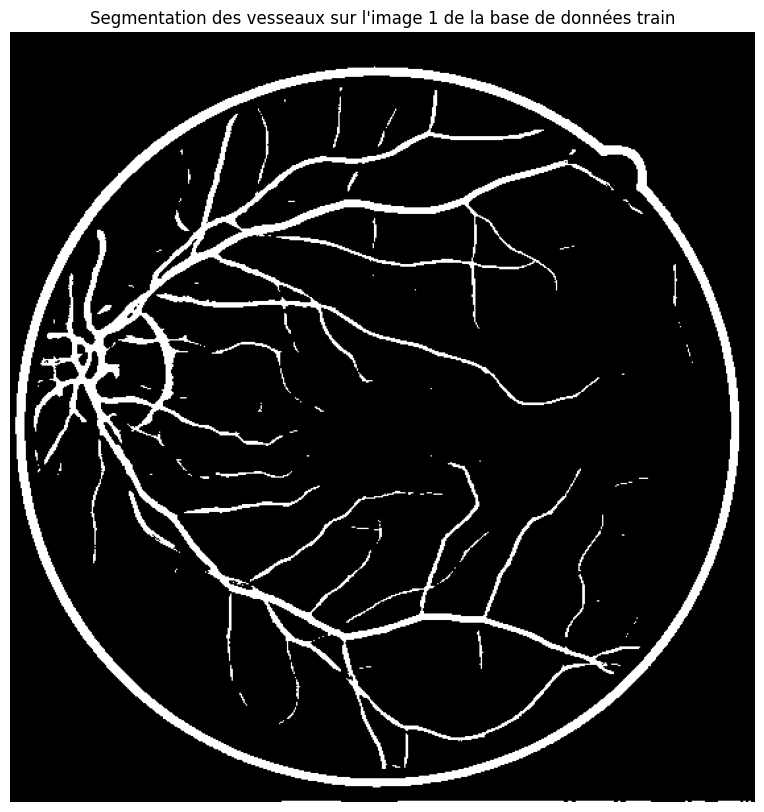

In [9]:
vessels_I1 = msld.segmentVessels(I1_Data)

plt.rcParams["figure.figsize"] = (12, 10)
plt.imshow(vessels_I1, cmap='gray', vmin = 0, vmax = 1)
plt.axis('off')
plt.title("Segmentation des vesseaux sur l'image 1 de la base de données train")
plt.show()

**Q13.**  Vous devriez voir apparaître des erreurs de segmentations aux bords du fond d’oeil. À quoi est
dû ce phénomène?



En appliquant la segmentation avec le seuil optimal sur la première image de la base de données *train*, on observe une amplification du contour qui définit le masque de la rétine. En effet, cette erreur est dû en raison de la détection des lignes qui peuvent constituer des bordures par le MSLD qui comporte une combinaison de BSLD avec différentes échelles. Il faut considérer le contraste entre le fond et la rétine, en outre sur le fenêtrage *W*, parmi les lignes de 12 orientations différentes, une est perpendiculaire et une autre est tangente. La ligne tangente à la rétine comporte un $I_{avg}$ élevée ce qui va hausser la bordure entre le fond et la rétine lors de l'application de l'algorithme. Par conséquence, on obtient une bordure qui défini la forme du masque de l'image de cette base de donnée d'entrainment.

**Q14.**   Pour palier à ce problème, dupliquer les datasets, et érodez les régions d’intérêts (les masques) de 10 pixels, puis effectuez l’apprentissage du seuil à nouveau. Comparer les valeurs du seuil et de la précision globale.



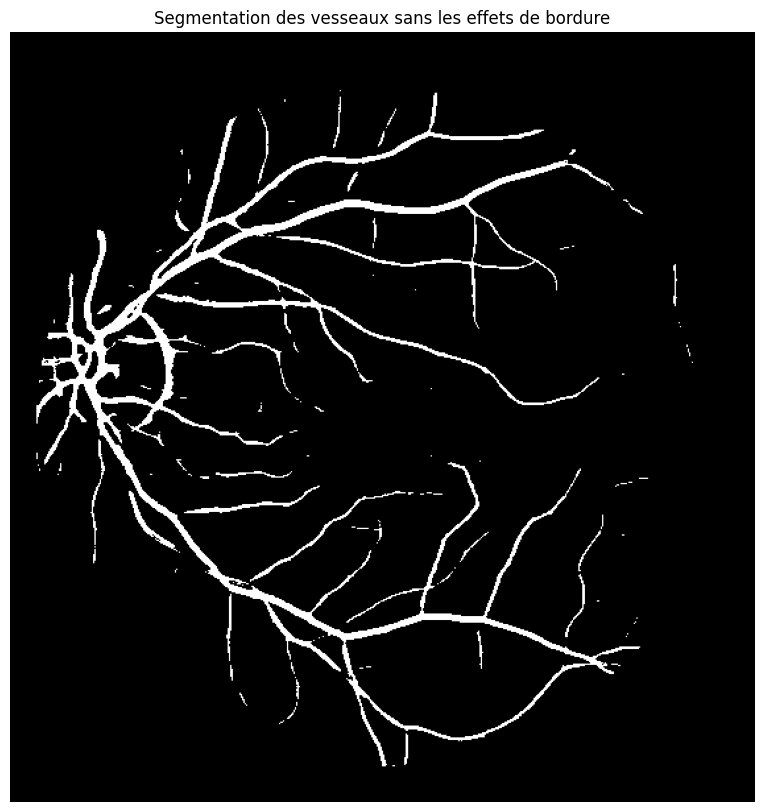

In [10]:
# Duplique les dataset
trainEroded = deepcopy(train)
testEroded = deepcopy(test)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))

for d in trainEroded:
    mask = d['mask']
    d['mask'] = cv2.erode(mask.astype(float),kernel, iterations=10) > 0.5

# Même opération pour test Eroded
for d in testEroded:
    mask = d['mask']
    d['mask'] = cv2.erode(mask.astype(float),kernel, iterations=10) > 0.5

# Test pour valider que l'érosion sur le mask enlève les erreurs de bordure
mask_test = trainEroded[0]['mask']
vessels_I1_mask = vessels_I1*mask_test
plt.rcParams["figure.figsize"] = (12, 10)
plt.imshow(vessels_I1_mask, cmap='gray', vmin = 0, vmax = 1)
plt.axis('off')
plt.title("Segmentation des vesseaux sans les effets de bordure")
plt.show()

In [11]:
threshold_trainEroded, accuracy_trainEroded = msld.learnThreshold(trainEroded)

In [12]:
print("Seuil de la binarisation de données d'entrainement avec masque érodé ||", "%.4f" % threshold_trainEroded,"||")
print("=================================================================================")
print("Précision de données d'entrainement avec masque érodé                ||", "%.4f" % accuracy_trainEroded,"||")
print("=================================================================================")

Seuil de la binarisation de données d'entrainement avec masque érodé || 0.5645 ||
Précision de données d'entrainement avec masque érodé                || 0.9345 ||


**Comparaison des précisions globales et seuils**

| Erosion               | Non          | Oui          |
| :-------------------- | :----------: | -----------: |
| Précision globale (%) | 92.49        | 93.45        |
| Seuil de binarisation | 0.5645       | 0.5645       |

Avec la table ci-dessus, on remarque que le seuil demeure constant même avec l'application des érosions sur les masques. Par contre, la précision globale à légèrement augmentée pour le cas où l'érosion a été appliquée au masque. Pour le seuil, il demeure constant car la méthode appliquée dans le *learnthreshold* consiste à chercher le seuil qui donne la précision maximale. Or, la précision maximale accroît pour tous les seuils en raison de la diminution de la détection des faux positifs qui sont causées par les effets de la bordure entre la rétine et le fond.

**Q15.** On vous donne la fonction `showDiff(sample) `qui affiche les faux positifs en rouge, les faux négatifs en bleu, les vrais positifs en blanc et les vrais négatifs en noirs.    
Avec cette fonction, affichez la différence entre la prédiction et le label sur l’image I1.

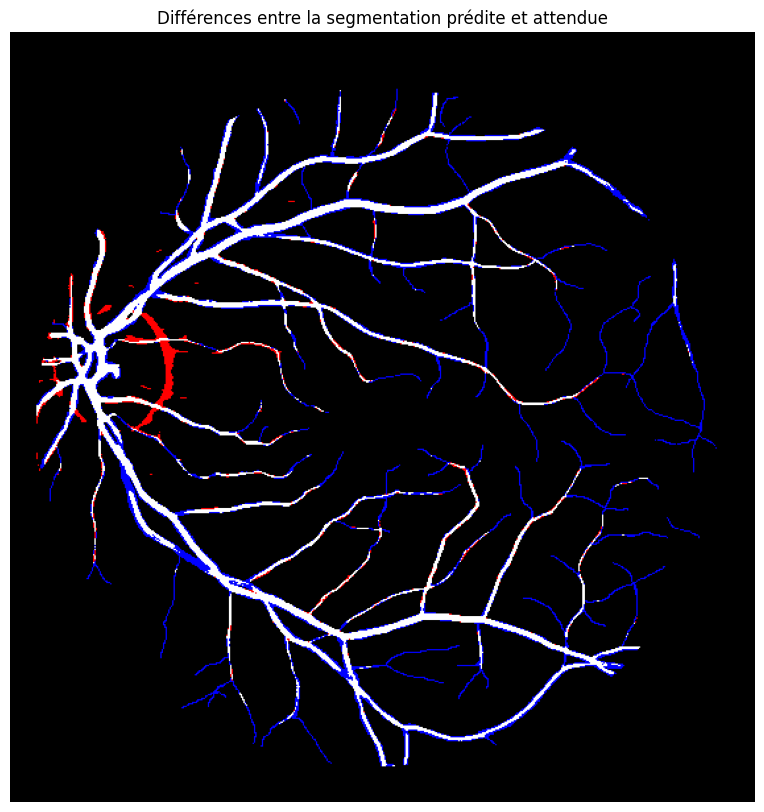

In [13]:
#msld.showDiff(I1)
msld.showDiff(trainEroded[0])

# Partie II:  Métriques de Segmentation

### Précision Globale et Locale

**Q1.** Implémentez la fonction `naiveMetric(dataset)` qui évalue la précision et la matrice de confu-
sion de l’algorithme pour un dataset donné. Puis calculez ces métriques sur l’ensemble de test.
*(N’oubliez pas de ne sélectionner que les pixels appartenant à la région d’intérêt!)*


In [14]:
accuracy_test, confusion_matrix_test = msld.naiveMetrics(test)

In [15]:
print("Matrice de confusion globale (en %): ")
print(np.around(confusion_matrix_test,2))
print("===================================================")
print("Précision globale (%): ", "%.2f" % accuracy_test, "%")

Matrice de confusion globale (en %): 
[[0.97 0.03]
 [0.38 0.62]]
Précision globale (%):  1.59 %


**Q2.** Les auteurs proposent une seconde métrique: la précision locale. Quelles raisons avancent-ils
pour motiver cette proposition?


La précision globale comporte des mesures qui sont difficiles à comparer avec d'autres méthodes de segmentation de vaisseaux de la rétine. En effet, on remarque que l'algorithme du ROC détecte facilement les N ce qui cause que dans la matrice de confusion, la valeur de TN est élévée. C'est cette valeur qui cause des précisions globales supérieures à 90%. Ainsi, pour pallier ce problème, les auteurs proposent d'utiliser la précision locale qui définit mieux la performance de l'algorithme de segmentation.

**Q3.** Grâce à une opération morphologique, créez une copie du dataset test tel que son attribut mask
corresponde à la région d’intérêt "locale" proposée par les auteurs. Puis, sans modifier la méthode
naiveMetric(dataset), calculez la précision et la matrice de confusion locale.


In [16]:
testArticle = deepcopy(test)
kernel_Dilate = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))

for d in testArticle:
    label = d['label']
    d['mask'] = cv2.dilate(label.astype(float), kernel_Dilate, iterations=1) > 0.5

accuracy_testArticle, confusion_matrix_testArticle = msld.naiveMetrics(testArticle)

print("Matrice de confusion local (en %): ")
print(np.around(confusion_matrix_testArticle,2))
print("===================================================")
print("Précision locale (%): ", "%.2f" % accuracy_testArticle, "%")

Matrice de confusion local (en %): 
[[0.9  0.1 ]
 [0.38 0.62]]
Précision locale (%):  1.52 %


**Q4.** Cette seconde métrique met plus en valeur l’algorithme proposé que la précision globale. Au vue
des erreurs de l’algorithme révélées à la question I.Q15, donnez une raison supplémentaire (omise par
les auteurs) qui explique ce phénomène.

Il est important de remarquer que le disque optique a été omis du label. Or, le MSLD détecte les contours de cette région de la rétine et par conséquence, le disque optique est présent dans la segmentation des vaisseaux.

### Indice Dice (Bonus)
De nombreux indices existent pour mieux évaluer les performances de segmentation que la précision globale (Précision balancée, Indice de Jaccard, Kappa de Cohen...). Nous allons ici utiliser l'indice Sørensen-Dice.
En notant $Y$ les labels et $\hat Y$ les prédictions de l'algorithme, l'indice Dice est défini par: $\text{Dice}(Y, \hat Y) = 2\dfrac{Y \cap \hat Y}{Y + \hat Y}$.

**Q5.** En quoi cette métrique répond aux limitations de la précision globale?

L'indice de S$\phi$rensen-Dice mesure la similarité entre deux échantillons. Cette métrique de segmentation est favorisée lors de l'évaluation des algorithmes de segmentations. En ce qui concerne les limitations de la précision globale, cette métrique accorde moins de poids aux cas déviants. En d'autres termes le fond qui constitue un problème de la précision globale n'influence pas énormement le résultat de l'indice Dice.


**Q6.** Implémentez la fonction `dice(dataset)` et calculez sa valeur sur la région d’intérêt globale et locale sur l’ensemble de test.


In [17]:
dice_index_global = msld.dice(test)
dice_index_local = msld.dice(testArticle)

In [18]:
print("Indice de Sorensen global ||","%.4f" %dice_index_global, "||")
print("=====================================")
print("Indice de Sorensen local  ||","%.4f" %dice_index_local, "||")

Indice de Sorensen global || 0.6894 ||
Indice de Sorensen local  || 0.7371 ||


### Courbe ROC et Aire sous la courbe (AUR)


Le choix d’un seuil de segmentation revient à faire un compromis entre faux-positifs et faux-négatifs (un seuil élevé limitera les faux-positifs mais augmentera les faux-négatifs et inversement). Le choix du bon compromis dépend bien souvent de l’application. Cependant les algorithmes se distinguent par le choix des caractéristiques à seuiller (ici un filtre MSLD) plutôt que par la méthode de sélection du seuil... [La courbe ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic##Area_under_the_curve) permet de représenter les performances de l’algorithme indépendamment du seuil choisi.   
Pour construire cette courbe, on calcule le taux de faux-positifs (FPR) et le taux de vrais-positifs (TPR=1−FNR) pour chaque valeur de seuil. La courbe obtenue (FPR en abscisse, TPR en ordonnée) caractérise l’efficacité de l’algorithme à distinguer les vaisseaux du fond, indépendamment du seuil.
Enfin, pour simplifier la comparaison entre deux courbes ROC, on extrait leurs [aires sous la courbe (AUR)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic##Area_under_the_curve).


**Q7.** Que signifie une AUR de 1, de 0,5 ou de 0 pour les performances du modèle?


**AUR = 1**

C'est le cas idéal, soit le modèle est capable de distinguer entre les positifs et les négatifs (aucun faux positifs ni faux négatifs).

**AUR = 0.5**

C'est le pire cas pour la classification du modèle. En outre la répartition de classe se comporte de façon aléatoire, ainsi le modèle ne peut pas distinguer précisement entre les positifs (vaisseaux) et les négatifs.


**AUR = 0**

Cette situation affirme que le modèle évalué prévoit une classe négative en tant que classe positive. En outre c'est l'inverse du cas $AUR=1$.

**Q8.**  Implémentez la méthode plotROC(dataset) qui trace la courbe ROC et calcule son AUR.  
Puis faites de même pour la région d’intérêt globale et pour la région d’intérêt locale. Comparez les résultats et commentez.

c:\Users\kpbea\Desktop\Projet MLSD\MSLD.py:428: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
c:\Users\kpbea\Desktop\Projet MLSD\MSLD.py:428: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


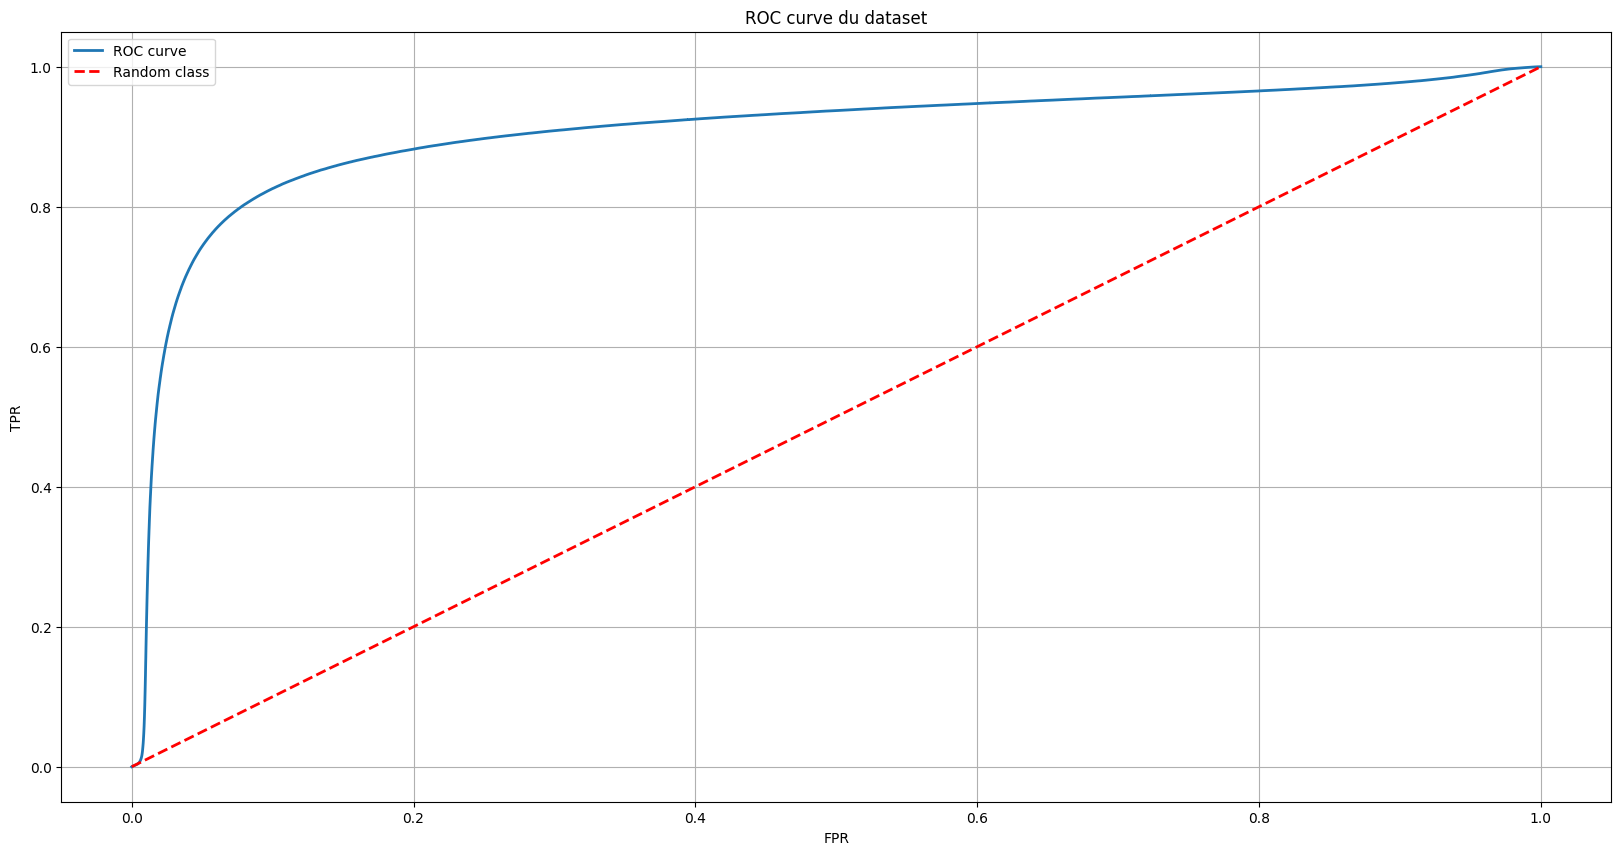

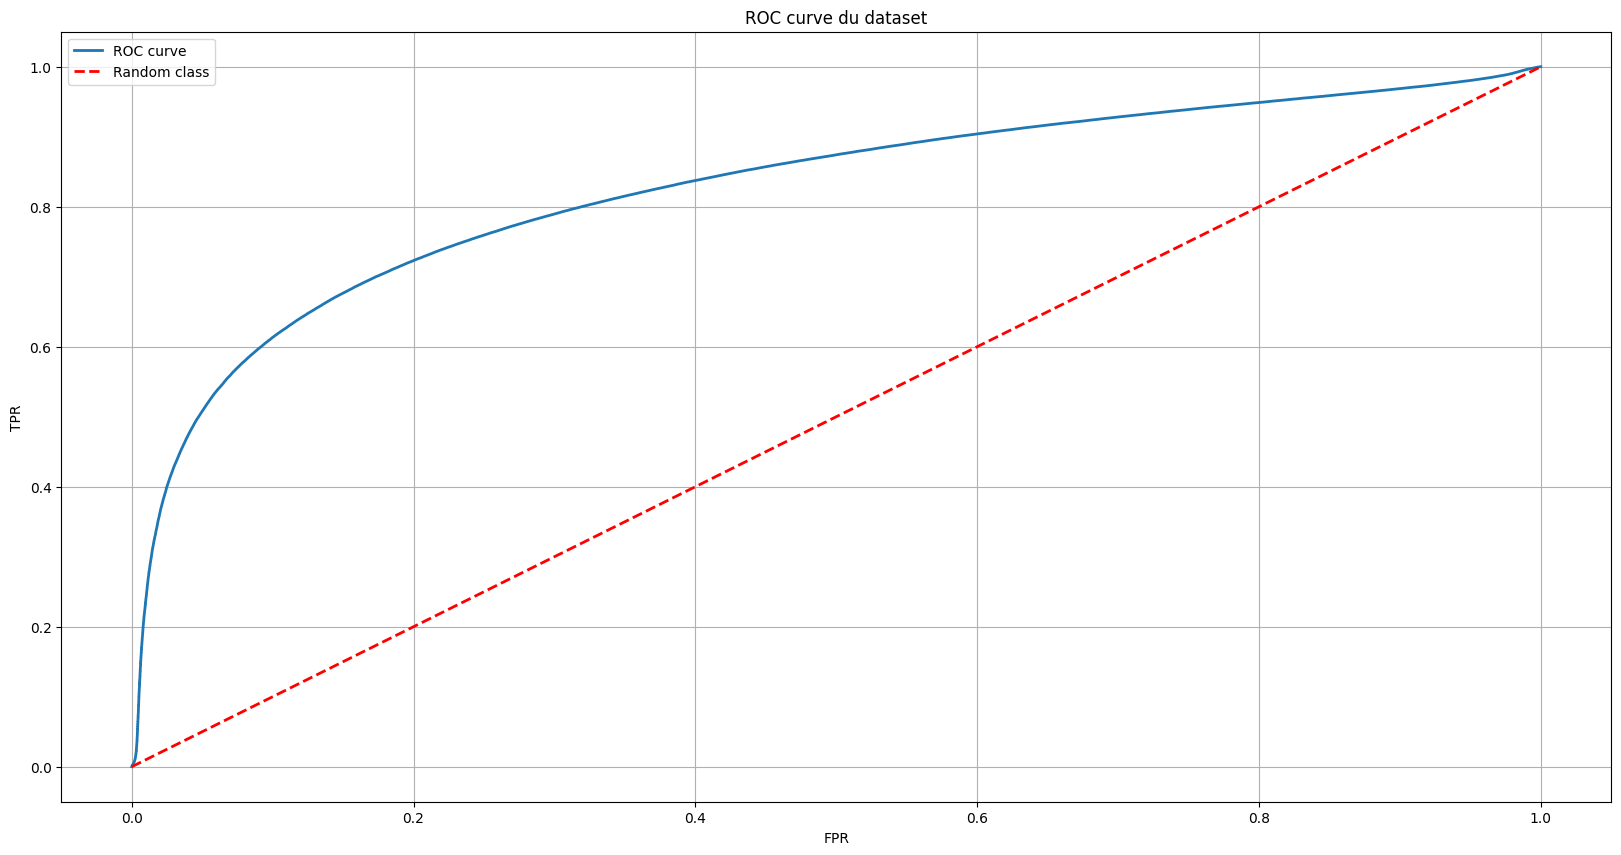

In [19]:
AUC_global = msld.plotROC(test)
AUC_local = msld.plotROC(testArticle)

In [20]:
print("ROC curve du test (Global) ||")
print("AUC global ||", "%.4f" %AUC_global, "      ||")
print("====================================")
print("ROC curve du test article (Local) ||")
print("AUC local  ||", "%.4f" %AUC_local, "             ||")

ROC curve du test (Global) ||
AUC global || 0.9062       ||
ROC curve du test article (Local) ||
AUC local  || 0.8248              ||


**Comparaison des résultats:**

On remarque que $AUC_{global} > AUC_{local}$, en outre le $AUC_{global}$ se rapproche du cas idéal par rapport au local. Puisque dans le cas local, la valeur des *FN* augmente, cela affecte les *TPR* pour les seuils appliquées. Ainsi la courbe ROC s'applatit et se rapproche du *Random class*. 

# Partie III: Validation de l’hypothèse de recherche de l’article

À l’aide de votre implémentation de l’algorithme et des différents cas du dataset de test, concluez sur
la validité de l’hypothèse de recherche de l’article (tel que vous l’aviez formulé dans le devoir 2).


**Hypothèse de recherche:**

La nouvelle technique proposée (Multi-Scale Line Detector) corrige les trois problèmes suivants : la fusion des vaisseaux sanguins rapprochés, la production d’extension aux points de croisement des vaisseaux et la production de fausses réponses de vaisseaux aux pixels de fond près des vaisseaux importants (vaisseaux avec des valeurs d'intensité élevées dans les images où les vaisseaux apparaissent plus brillants que le fond).

**Observations de nos résultats:**

Malgré qu'on obtienne une précision élevée, on peut remarquer que les petits vaisseaux ne sont pas détectés. Cela peut être expliqué par le fait qu'en terme de pixels, les gros vaisseaux (qui ont été bien segmentés) sont beaucoup plus nombreux et ont alors beaucoup plus de poids dans le calcul de la précision. De plus, des nombreuses erreurs sont survenus lorsqu’on applique le seuil à la réponse du MSLD qui sont résumés dans la liste ci-dessus. 

- La réponse n'est pas assez importante dans le zones de croissement de vaisseaux 
- Perte des petits vaisseaux dans la segmentation
- Perte des pixels de vaisseaux dans certaines birfucations
- Conservation du disque optique dans la segmentation des vaisseaux

Ainsi, à la lumière de ces observations, on infirme l'hypothèse de recherche à partir des résultats que nous avons obtenus.

# Partie  IV: Discussion


À l’aide de votre implémentation de l’algorithme et des différents cas du dataset de test, concluez sur
la validité de l’hypothèse de recherche de l’article (tel que vous l’aviez formulé dans le devoir 2).


**Q1.** Discutez du choix des hyper-paramètres W, L (nombre d’échelles et répartition) et n_orientation.   
Leurs valeurs ont-elles des justifications théoriques? Quels sont leur impact en pratique?

**Justification théorique:**

Hyper-paramètre L:

- On prend des valeurs d'échelles entre 1 et 15 car on veut détecter les vaisseaux sanguins de toutes les longueurs: 1 est la plus petite longueur possible (pour détecter les petits vaisseaux) et 15 pour éliminer le bruit de fond
- On utilise une répartition contenant toutes les valeurs impaires entre les bornes 1 et 15 pour la taille des lignes

Hyper-paramètre W:

Selon l'article, la longueur typique de vaisseaux de la base de données *DRIVE* est entre 7 et 8 pixels. Ainsi, on applique une fenêtre de 15 par 15 pixel pour bien encadrer les vaisseaux.

Hyper-paramètre n:

Les auteurs proposent d'utiliser une résolution angulaire de 15° ce qui se traduit à une fênetre avec des lignes qui ont 12 orientations. Ce nombre d'orientation permet de couvrir les pixels voisins afin de bien detecter les vaisseaux.

**Impacts:**

Hyper-paramètre L: 
- Un petit L permet de détecter les petits vaisseaux, mais introduit beaucoup de bruit 
- Un grand L permet de détecter les longs sans bruit de fond, mais la réponse est lisse 

Hyper-paramètre W:
- Diminue le nombre d'éléments qui entre dans la combinaison linéaire
- Si il diminue, on augmente le bruit de fond et l'effet de la réflection centrale est accentuée

Hyper-paramètre n:
- Si n diminue, le nombre de lignes de la fenêtre diminue, alors la résolution angulaire diminue et on a moins de chance de trouver la bonne orientation
- Pour n > 12, il n'y a aucun effet car on est déja à la limite de la résolution angulaire
        

**Q2.** Les auteurs ont choisi le seuil donnant la meilleure précision sur l’ensemble d’entraînement. 
Connaissant les analyses effectuées dans la partie II, discutez de ce choix.

|        |  Précision  |  Indice de Sorensen  |      AUC     |    Seuil d'apprentissage    | 
|:------:|:-----------:|:--------------------:|:------------:|:------------:|
| Global |   92.90 %   |         0.6894       |     0.9062   |     0.5645   |
| Local  |   72.14 %   |         0.7371       |     0.8248   |     0.5645   |

Puisqu'on a choisi notre seuil selon la précision on n'a pas nécessairement le seuil optimal selon la courbe ROC. En outre le seuil optimal de la courbe ROC correspond au seuil du point le plus près du cas idéal (AUR = 1). Cependant, on a obtenu le même seuil d'apprentissage que celui des auteurs de l'article.

**Q3.** En vous appuyant sur vos expérimentations pour les deux dernières parties de cet énoncé, proposez des recommandations pour améliorer l’algorithme.

- Prendre le seuil qui se rapproche le plus du cas idéal (AUR = 1)
- Pour le cas où les échelles sont petites, on pourrait appliquer des filtres qui atténuent les granularités 
- On peut applique une analyse sur l'entropie des pixel sur la réponse du MSLD afin d'extraire les vaisseaux sans perdre de l'information lors de la segmentation avec le seuil d'apprentissage
- Au lieu d'introduire le ROC pour extraire le seuil optimal, on peut miser sur l'indice DICE (métrique favorisée lors des segmentations)